In [ ]:
!pip install gcsfs

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c motorcycle-night-ride-semantic-segmentation

In [1]:
!pip install utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiffel/main_quest/Motorcycle Night Ride Dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/aiffel/main_quest/Motorcycle Night Ride Dataset


In [3]:
# 라이브러리

import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.io as io

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from pycocotools.coco import COCO

from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Conv2D
from keras.layers import BatchNormalization, MaxPooling2D
from keras.layers import Conv2DTranspose, Concatenate
from keras.models import Model
from keras import callbacks
from keras.callbacks import ModelCheckpoint
from keras import utils


import math
import cv2

In [4]:
# 이미지 파일 로드
datapath = './images'
dataset = datapath + '/*'

In [5]:
filenames = tf.io.gfile.glob(dataset)

In [6]:
print(len(filenames))

600


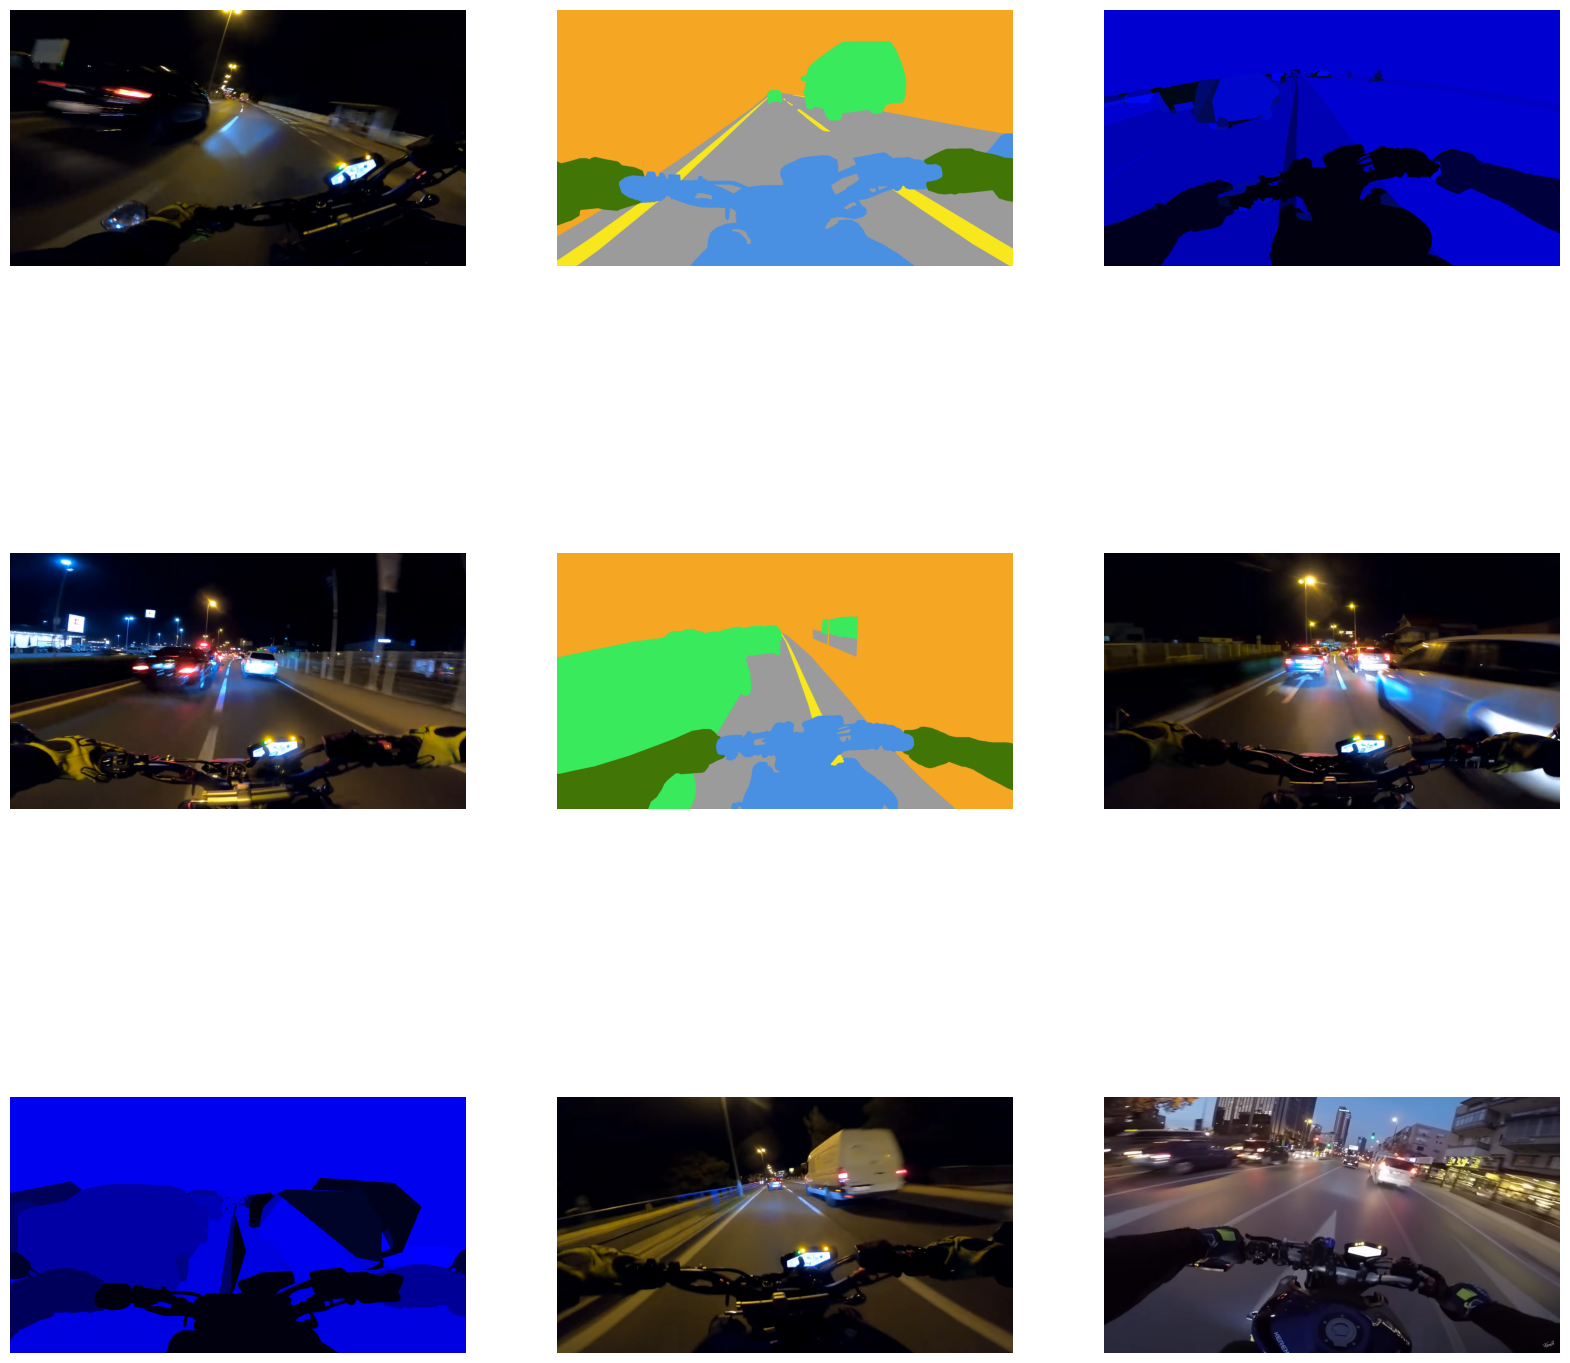

In [7]:
# Display the 9 images
fig, axs = plt.subplots(3, 3, figsize=(20,20))

for i, filename in enumerate(filenames[:9]):
    row = i // 3
    col = i % 3

    img = mpimg.imread(filename)
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

plt.show()

위 이미지 파일만 가지고는 supervised learning 불가

target 필요

In [8]:
# json file 내 데이터 확인
coco_file = './COCO_motorcycle (pixel).json'

In [9]:
coco = COCO(coco_file)

loading annotations into memory...
Done (t=10.73s)
creating index...
index created!


In [10]:
# Image id, Category id를 input으로, 그에 해당하는 annotation id를 return 하는 함수입니다.
for i in range(5):
  print(coco.getAnnIds(imgIds = i))

[]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [11]:
# COCO categories 확인
#Category 이름, Super Category 이름을 input으로, 그에 해당하는 Category  id를 return하는 함수입니다.
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(catIDs , '\n\n', cats)

[1329681, 1323885, 1323884, 1323882, 1323881, 1323880] 

 [{'id': 1329681, 'name': 'Rider', 'supercategory': 'Rider', 'isthing': 1, 'color': [17, 74, 20]}, {'id': 1323885, 'name': 'My bike', 'supercategory': 'My bike', 'isthing': 1, 'color': [109, 51, 20]}, {'id': 1323884, 'name': 'Moveable', 'supercategory': 'Moveable', 'isthing': 1, 'color': [108, 51, 20]}, {'id': 1323882, 'name': 'Lane Mark', 'supercategory': 'Lane Mark', 'isthing': 1, 'color': [106, 51, 20]}, {'id': 1323881, 'name': 'Road', 'supercategory': 'Road', 'isthing': 1, 'color': [105, 51, 20]}, {'id': 1323880, 'name': 'Undrivable', 'supercategory': 'Undrivable', 'isthing': 1, 'color': [104, 51, 20]}]


In [12]:
for i in range(6):
  print(cats[i] ,"\n")

{'id': 1329681, 'name': 'Rider', 'supercategory': 'Rider', 'isthing': 1, 'color': [17, 74, 20]} 

{'id': 1323885, 'name': 'My bike', 'supercategory': 'My bike', 'isthing': 1, 'color': [109, 51, 20]} 

{'id': 1323884, 'name': 'Moveable', 'supercategory': 'Moveable', 'isthing': 1, 'color': [108, 51, 20]} 

{'id': 1323882, 'name': 'Lane Mark', 'supercategory': 'Lane Mark', 'isthing': 1, 'color': [106, 51, 20]} 

{'id': 1323881, 'name': 'Road', 'supercategory': 'Road', 'isthing': 1, 'color': [105, 51, 20]} 

{'id': 1323880, 'name': 'Undrivable', 'supercategory': 'Undrivable', 'isthing': 1, 'color': [104, 51, 20]} 



In [13]:
name = [cat['name'] for cat in cats]
supercategory = [cat['supercategory'] for cat in cats]

print(len(name), "name : {}".format('  '.join(name)))
print(len(supercategory), "supercategory : {}".format('  '.join(supercategory)))

6 name : Rider  My bike  Moveable  Lane Mark  Road  Undrivable
6 supercategory : Rider  My bike  Moveable  Lane Mark  Road  Undrivable


In [14]:
#Img id, Category id를 input으로, 그에 해당하는 Image id를 return하는 함수입니다
imgIDs = coco.getImgIds(catIDs)
print(imgIDs)

[1323880, 1323881, 1323882, 1323884, 1323885, 1329681]


In [15]:
img = coco.loadImgs(5)
print(img)

[{'id': 5, 'file_name': 'night ride (23).png', 'height': 1080, 'width': 1920, 'license': 1}]


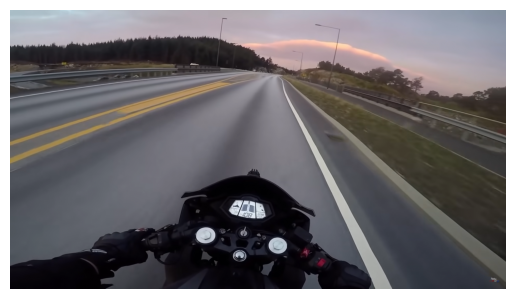

In [16]:
img = coco.loadImgs(np.random.randint(1,201))[0]  # data 600개에 fuse, save, original 3개로 분할 되어서 200개
screenshot = io.imread('{}//{}'.format(datapath,img['file_name']))/255.0   # plt는 데이터 다룰 때, 0~1 사이값으로 다룸
plt.axis('off')
plt.imshow(screenshot)
plt.show()

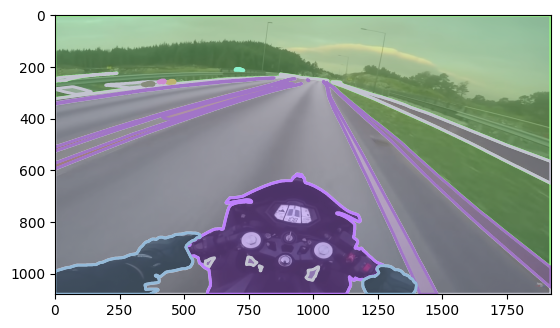

In [17]:
plt.imshow(screenshot)
annIDs = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
# Annotation id를 input으로 annotation dict 전체를 return하는 함수
anns = coco.loadAnns(annIDs)
coco.showAnns(anns)

In [18]:
print(anns,"\n\n",annIDs)

[{'id': 1109, 'image_id': 105, 'segmentation': [[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0, 7, 0, 8, 0, 9, 0, 10, 0, 11, 0, 12, 0, 13, 0, 14, 0, 15, 0, 16, 0, 17, 0, 18, 0, 19, 0, 20, 0, 21, 0, 22, 0, 23, 0, 24, 0, 25, 0, 26, 0, 27, 0, 28, 0, 29, 0, 30, 0, 31, 0, 32, 0, 33, 0, 34, 0, 35, 0, 36, 0, 37, 0, 38, 0, 39, 0, 40, 0, 41, 0, 42, 0, 43, 0, 44, 0, 45, 0, 46, 0, 47, 0, 48, 0, 49, 0, 50, 0, 51, 0, 52, 0, 53, 0, 54, 0, 55, 0, 56, 0, 57, 0, 58, 0, 59, 0, 60, 0, 61, 0, 62, 0, 63, 0, 64, 0, 65, 0, 66, 0, 67, 0, 68, 0, 69, 0, 70, 0, 71, 0, 72, 0, 73, 0, 74, 0, 75, 0, 76, 0, 77, 0, 78, 0, 79, 0, 80, 0, 81, 0, 82, 0, 83, 0, 84, 0, 85, 0, 86, 0, 87, 0, 88, 0, 89, 0, 90, 0, 91, 0, 92, 0, 93, 0, 94, 0, 95, 0, 96, 0, 97, 0, 98, 0, 99, 0, 100, 0, 101, 0, 102, 0, 103, 0, 104, 0, 105, 0, 106, 0, 107, 0, 108, 0, 109, 0, 110, 0, 111, 0, 112, 0, 113, 0, 114, 0, 115, 0, 116, 0, 117, 0, 118, 0, 119, 0, 120, 0, 121, 0, 122, 0, 123, 0, 124, 0, 125, 0, 126, 0, 127, 0, 128, 0, 129, 0, 130, 0, 131, 0, 13

In [19]:
# Assume anns is a list of annotation dictionaries
first_annotation = anns[0]

# Print the keys of the first annotation
for key in first_annotation.keys():
    print(key)

id
image_id
segmentation
iscrowd
bbox
area
category_id


In [20]:
classid = []
classname=[]

for i in range(len(anns)):
  for j in range(len(cats)) :
    if cats[j]['id'] == anns[i]['category_id'] :
      classid.append(anns[i]['category_id'])
      classname.append(cats[j]['name'])


print("class id : ",classid , "\n\n","classname : ", classname)

class id :  [1323880, 1323881, 1323882, 1323884, 1323884, 1323884, 1323884, 1323885, 1329681] 

 classname :  ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'Moveable', 'Moveable', 'Moveable', 'My bike', 'Rider']


In [21]:
def classname(ID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==ID:
            return cats[i]['name']


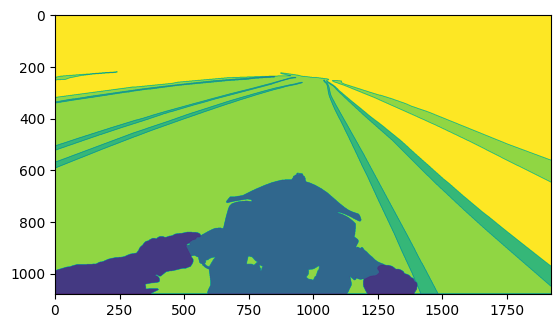

In [22]:
Classes = ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = classname(anns[i]['category_id'], cats)
    pixel_value = Classes.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)

plt.imshow(mask)

# Train test set 분리

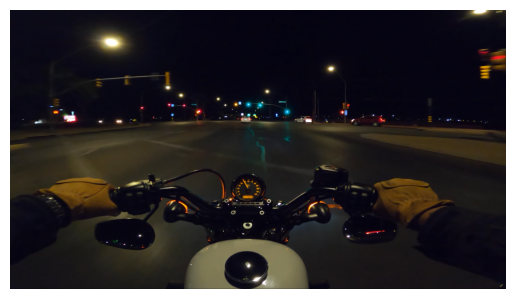

In [23]:
img = coco.loadImgs(np.random.randint(1,201))[0]  # data 600개에 fuse, save, original 3개로 분할 되어서 200개
screenshot = io.imread('{}/{}'.format(datapath,img['file_name']))/255.0   # plt는 데이터 다룰 때, 0~1 사이값으로 다룸
plt.axis('off')
plt.imshow(screenshot)
plt.show()

In [24]:
imgs = []
for i in range(1, 201):
  imgs.append(coco.loadImgs(i)[0])

print(imgs)
print(imgs[0])

[{'id': 1, 'file_name': 'night ride (8).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 2, 'file_name': 'night ride (14).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 3, 'file_name': 'night ride (11).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 4, 'file_name': 'night ride (24).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 5, 'file_name': 'night ride (23).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 6, 'file_name': 'night ride (10).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 7, 'file_name': 'night ride (9).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 8, 'file_name': 'night ride (20).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 9, 'file_name': 'night ride (12).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 10, 'file_name': 'night ride (17).png', 'height': 1080, 'width': 1920, 'license': 1}, {'id': 11, 'file_name': 'night ride (7).png', 'height': 1080, 'width': 1920, 'li

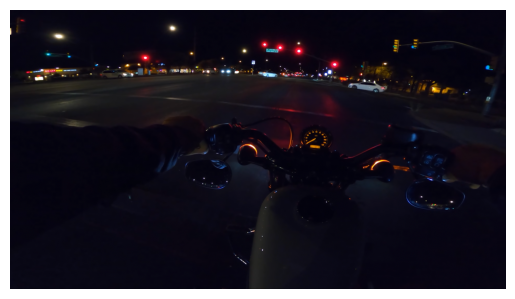

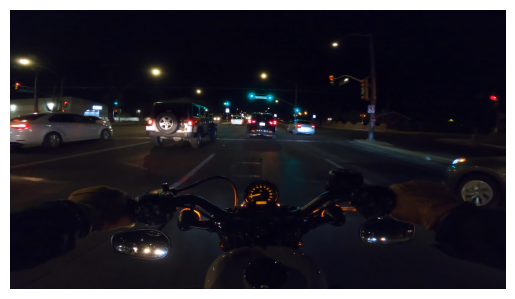

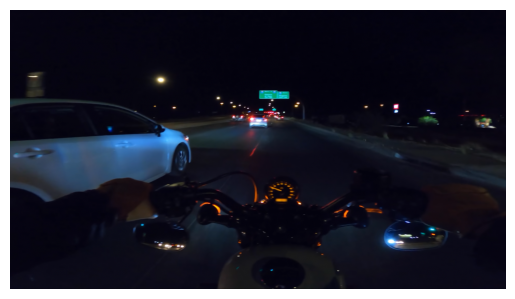

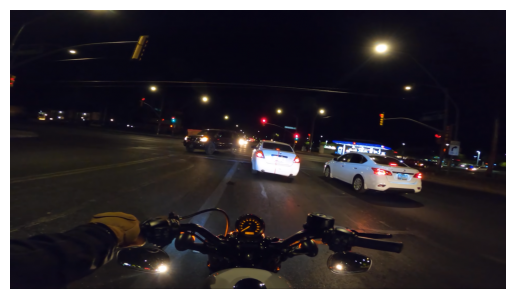

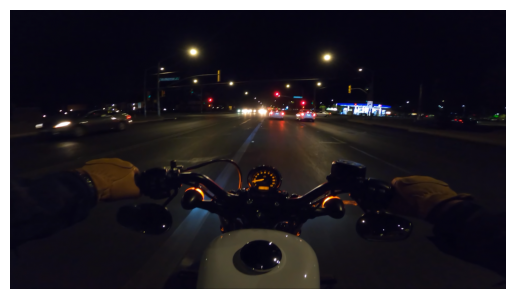

In [25]:
for i in range(5):
  screen = io.imread('{}/{}'.format(datapath,imgs[i]['file_name']))/255.0   # plt는 데이터 다룰 때, 0~1 사이값으로 다룸
  plt.axis('off')
  plt.imshow(screen)
  plt.show()

In [47]:
img_size = (128, 128)

def get_img_array(path,img_size) :
  img = keras.utils.load_img(path, target_size = img_size)
  array = keras.utils.img_to_array(img)
  return array


In [48]:
images =[]
for i in range(len(imgs)):
  path = datapath + '/'+ imgs[i]['file_name']
  images.append(get_img_array(path, img_size))


In [49]:
images_array = np.array(images)

print(images_array.shape)

(200, 128, 128, 3)


In [58]:
TRAIN_LENGTH = int(len(images) * 0.2)

In [68]:
train_image = images[:-TRAIN_LENGTH]
val_image = images[-TRAIN_LENGTH:]
test_image = train_image[-TRAIN_LENGTH:]
train_image = train_image[:-TRAIN_LENGTH]
print(len(train_image), len(val_image), len(test_image))

120 40 40


In [63]:
def classid(ID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==ID:
            return cats[i]['id']

In [66]:
target = []
Classes = ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
for i in range(len(anns)):
    className = classname(anns[i]['category_id'], cats)
    pixel_value = Classes.index(className)+1
    mask = coco.annToMask(anns[i])*pixel_value
    print(className)
    print(pixel_value)

Undrivable
6
Road
5
Lane Mark
4
Moveable
3
Moveable
3
Moveable
3
Moveable
3
My bike
2
Rider
1


target을 뽑아낼 방법을 모르겠다.

target값이 너무 많아

가장많은 값으로 뽑아야 하는건가?

# UNET 적용

In [28]:
def conv_batch_act(layer, filters) :
  conv1 = Conv2D(filters, 3, padding ='same')(layer)
  batch1 = BatchNormalization()(conv1)
  act1 = Activation('relu')(batch1)
  conv2 = Conv2D(filters, 3, padding ='same')(act1)
  batch2 = BatchNormalization()(conv2)
  act2 = Activation('relu')(batch2)
  return act2

def encoder(layer, filters) :
  conv = conv_batch_act(layer, filters)
  pool = MaxPooling2D(2)(conv)
  return conv, pool

def decoder(layer, filters, concat):
  convT = Conv2DTranspose(filters, 2, strides=2, padding='same')(layer)
  con = Concatenate()([convT,concat])
  cba = conv_batch_act(con, filters)
  return cba

In [29]:
def UNET(input_shape = (128,128,3)):
  inputs =Input(input_shape)

  c1, p1 = encoder(inputs, 64)
  c2, p2 = encoder(p1, 128)
  c3, p3 = encoder(p2, 256)
  c4, p4 = encoder(p3, 512)

  bridge = conv_batch_act(p4, 1024)

  d1 = decoder(bridge, 512, c4)
  d2 = decoder(d1, 256 , c3)
  d3 = decoder(d2, 128 , c2)
  d4 = decoder(d3, 64 , c1)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
  model = Model(inputs = inputs, outputs = outputs)

  return model

In [30]:
model = UNET(input_shape=(128, 128, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

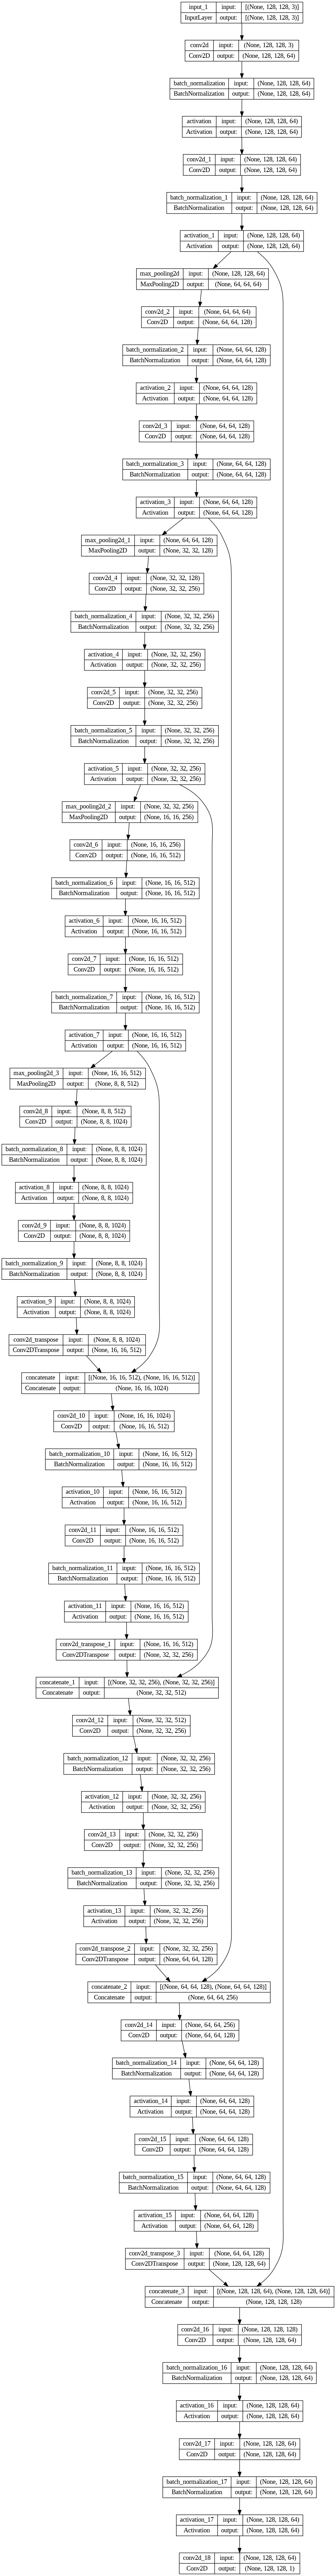

In [31]:
utils.plot_model(model, show_shapes =True)

In [70]:
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks =[ModelCheckpoint('segmentation.keras', save_best_only=True),
            keras.callbacks.TensorBoard(log_dir = './')]

history = model.fit(train_image, train_target,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_image, val_target))

NameError: ignored

# Reference

* coco dataset.json file 읽기 및 정리 :

  https://comlini8-8.tistory.com/67

	https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
  
	https://walkaroundthedevelop.tistory.com/133

  


* U-NET 구조 :
  
  https://velog.io/@lighthouse97/UNet%EC%9D%98-%EC%9D%B4%ED%95%B4

# 결론

target 뽑아내려고 이것저것 해봤지만 하는 법을 모르겠다.

흠,,,,